# Multi-Class Classification Model for Crop Mapping in Canada Using Scikit-Learn Take 1
### David Lowe
### July 9, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Crop Mapping in Canada dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: This data set is a fused bi-temporal optical-radar data for cropland classification. The organization collected the images using RapidEye satellites (optical) and the Unmanned Aerial Vehicle Synthetic Aperture Radar (UAVSAR) system (Radar) over an agricultural region near Winnipeg, Manitoba, Canada in 2012. There are 2 * 49 radar features and 2 * 38 optical features for two dates: 05 and 14 July 2012. Seven crop type classes exist for this data set as follows: 1-Corn; 2-Peas; 3-Canola; 4-Soybeans; 5-Oats; 6-Wheat; and 7-Broadleaf.

In this Take1 iteration, we will construct and tune machine learning models for this dataset using the Scikit-Learn library. We will observe the best accuracy result that we can obtain using the tuned models with the training and test datasets.

ANALYSIS: From this Take1 iteration, the performance of the machine learning algorithms achieved a baseline average accuracy of 99.24%. Two algorithms (Extra Trees and k-Nearest Neighbors) achieved the top accuracy metrics after the first round of modeling. After a series of tuning trials, the Extra Trees model processed the training dataset with an accuracy scoreof 99.72%. When configured with the optimized parameters, the Extra Trees model processed the test dataset with an accuracy score of 99.74%, which was consistent with the prediction accuracy from the training dataset.

CONCLUSION: For this iteration, the Extra Trees model achieved the best overall results using the training and test datasets. For this dataset, we should consider using the Extra Trees algorithm for further modeling.

Dataset Used: Crop Mapping in Canada Data Set

Dataset ML Model: Multi-Class classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Crop+mapping+using+fused+optical-radar+data+set

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import smtplib
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN
# from imblearn.combine import SMOTETomek

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.ensemble import RUSBoostClassifier
# from imblearn.ensemble import BalancedBaggingClassifier
# from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = True

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = "arn:aws:sns:us-east-1:072417399597:PythonMLScriptNotification"
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/crop-mapping-winnipeg/WinnipegDataset.txt'
Xy_original = pd.read_csv(dataset_path)

# Take a peek at the dataframe after import
Xy_original.head(10)

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,...,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,...,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,...,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,1,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,...,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,1,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,...,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000
5,1,-12.478,-19.034,-9.6201,-12.888,-10.761,-13.687,-2.8583,-6.5555,-9.4138,...,0.28395,0.93405,2.2222,0.395060,0.77778,0.44444,0.44444,0.93689,0.43210,0.18898
6,1,-12.459,-19.019,-9.3854,-12.766,-10.664,-13.393,-3.0739,-6.5599,-9.6338,...,0.16049,-0.21651,1.8889,0.098765,0.88889,0.22222,0.22222,0.68374,0.62963,-0.12500
7,1,-12.721,-19.057,-9.4054,-12.887,-10.797,-13.384,-3.3153,-6.3366,-9.6519,...,0.23457,-0.28737,1.6667,0.222220,0.83333,0.33333,0.33333,1.27300,0.30864,0.31623
8,1,-12.777,-19.202,-9.2785,-12.905,-10.762,-13.213,-3.4982,-6.4252,-9.9234,...,0.33333,0.47434,1.4444,0.246910,0.61111,0.77778,0.77778,1.21490,0.33333,-0.55000
9,1,-12.804,-19.273,-9.2722,-12.937,-10.802,-13.143,-3.5322,-6.4682,-10.0000,...,0.23457,0.31623,1.7778,0.172840,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898


In [11]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Data columns (total 175 columns):
 #   Column  Dtype  
---  ------  -----  
 0   label   int64  
 1   f1      float64
 2   f2      float64
 3   f3      float64
 4   f4      float64
 5   f5      float64
 6   f6      float64
 7   f7      float64
 8   f8      float64
 9   f9      float64
 10  f10     float64
 11  f11     float64
 12  f12     float64
 13  f13     float64
 14  f14     float64
 15  f15     float64
 16  f16     float64
 17  f17     float64
 18  f18     float64
 19  f19     float64
 20  f20     float64
 21  f21     float64
 22  f22     float64
 23  f23     float64
 24  f24     float64
 25  f25     float64
 26  f26     float64
 27  f27     float64
 28  f28     float64
 29  f29     float64
 30  f30     float64
 31  f31     float64
 32  f32     float64
 33  f33     float64
 34  f34     float64
 35  f35     float64
 36  f36     float64
 37  f37     float64
 38  f38     float64
 39  f39     float64
 40  f

In [12]:
Xy_original.describe()

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,...,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,4.062421,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,...,0.433834,0.329085,2.171177,0.080138,0.919604,0.174447,0.162900,0.403288,0.764646,0.667567
std,1.604617,3.504255,4.054214,3.267857,3.71163,3.189013,3.675741,1.682060,1.204040,2.002658,...,0.245857,0.442008,1.284653,0.182628,0.105953,0.373726,0.222008,0.480141,0.273847,0.471260
min,1.000000,-23.971000,-34.308000,-23.161000,-27.24500,-22.103000,-26.897000,-5.582600,-16.389000,-16.558000,...,0.111110,-1.000000,0.000000,0.000000,0.106190,0.000000,0.000000,-0.000000,0.111110,-1.000000
25%,3.000000,-17.848000,-27.119000,-17.563000,-21.44900,-16.989000,-21.450000,-1.037800,-9.658500,-10.070000,...,0.259260,0.000000,1.000000,0.000000,0.833330,0.000000,0.000000,-0.000000,0.506170,0.357140
50%,4.000000,-15.992000,-25.064000,-16.164000,-19.58800,-15.099000,-19.282000,0.309180,-8.915900,-8.733100,...,0.358020,0.357140,2.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,1.000000,1.000000
75%,6.000000,-11.786000,-20.387000,-13.427000,-15.65000,-11.735000,-15.514000,1.558200,-8.190200,-7.158100,...,0.506170,0.661440,3.000000,0.172840,1.000000,0.333330,0.333330,0.848690,1.000000,1.000000
max,7.000000,2.535600,-7.589100,1.104000,0.77491,-0.887390,0.951780,7.029900,-1.175400,-0.924610,...,1.000000,1.000000,12.444000,25.951000,1.000000,66.667000,6.666700,2.197200,1.000000,1.000000


In [13]:
Xy_original.isnull().sum()

label    0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
f9       0
f10      0
f11      0
f12      0
f13      0
f14      0
f15      0
f16      0
f17      0
f18      0
f19      0
f20      0
f21      0
f22      0
f23      0
f24      0
f25      0
f26      0
f27      0
f28      0
f29      0
f30      0
f31      0
f32      0
f33      0
f34      0
f35      0
f36      0
f37      0
f38      0
f39      0
f40      0
f41      0
f42      0
f43      0
f44      0
f45      0
f46      0
f47      0
f48      0
f49      0
f50      0
f51      0
f52      0
f53      0
f54      0
f55      0
f56      0
f57      0
f58      0
f59      0
f60      0
f61      0
f62      0
f63      0
f64      0
f65      0
f66      0
f67      0
f68      0
f69      0
f70      0
f71      0
f72      0
f73      0
f74      0
f75      0
f76      0
f77      0
f78      0
f79      0
f80      0
f81      0
f82      0
f83      0
f84      0
f85      0
f86      0
f87      0
f88      0
f89      0
f90      0

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'label': 'targetVar'})

# Convert columns from one data type to another
Xy_original['f137'] = Xy_original['f137'].astype('float')
Xy_original['f138'] = Xy_original['f138'].astype('float')
Xy_original['f139'] = Xy_original['f139'].astype('float')
Xy_original['f140'] = Xy_original['f140'].astype('float')
Xy_original['f141'] = Xy_original['f141'].astype('float')

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,targetVar,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,...,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,...,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,...,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,1,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,...,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,1,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,...,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000
5,1,-12.478,-19.034,-9.6201,-12.888,-10.761,-13.687,-2.8583,-6.5555,-9.4138,...,0.28395,0.93405,2.2222,0.395060,0.77778,0.44444,0.44444,0.93689,0.43210,0.18898
6,1,-12.459,-19.019,-9.3854,-12.766,-10.664,-13.393,-3.0739,-6.5599,-9.6338,...,0.16049,-0.21651,1.8889,0.098765,0.88889,0.22222,0.22222,0.68374,0.62963,-0.12500
7,1,-12.721,-19.057,-9.4054,-12.887,-10.797,-13.384,-3.3153,-6.3366,-9.6519,...,0.23457,-0.28737,1.6667,0.222220,0.83333,0.33333,0.33333,1.27300,0.30864,0.31623
8,1,-12.777,-19.202,-9.2785,-12.905,-10.762,-13.213,-3.4982,-6.4252,-9.9234,...,0.33333,0.47434,1.4444,0.246910,0.61111,0.77778,0.77778,1.21490,0.33333,-0.55000
9,1,-12.804,-19.273,-9.2722,-12.937,-10.802,-13.143,-3.5322,-6.4682,-10.0000,...,0.23457,0.31623,1.7778,0.172840,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898


In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Data columns (total 175 columns):
 #   Column     Dtype  
---  ------     -----  
 0   targetVar  int64  
 1   f1         float64
 2   f2         float64
 3   f3         float64
 4   f4         float64
 5   f5         float64
 6   f6         float64
 7   f7         float64
 8   f8         float64
 9   f9         float64
 10  f10        float64
 11  f11        float64
 12  f12        float64
 13  f13        float64
 14  f14        float64
 15  f15        float64
 16  f16        float64
 17  f17        float64
 18  f18        float64
 19  f19        float64
 20  f20        float64
 21  f21        float64
 22  f22        float64
 23  f23        float64
 24  f24        float64
 25  f25        float64
 26  f26        float64
 27  f27        float64
 28  f28        float64
 29  f29        float64
 30  f30        float64
 31  f31        float64
 32  f32        float64
 33  f33        float64
 34  f34        float64


In [17]:
Xy_original.describe()

,targetVar,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,...,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,4.062421,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,...,0.433834,0.329085,2.171177,0.080138,0.919604,0.174447,0.162900,0.403288,0.764646,0.667567
std,1.604617,3.504255,4.054214,3.267857,3.71163,3.189013,3.675741,1.682060,1.204040,2.002658,...,0.245857,0.442008,1.284653,0.182628,0.105953,0.373726,0.222008,0.480141,0.273847,0.471260
min,1.000000,-23.971000,-34.308000,-23.161000,-27.24500,-22.103000,-26.897000,-5.582600,-16.389000,-16.558000,...,0.111110,-1.000000,0.000000,0.000000,0.106190,0.000000,0.000000,-0.000000,0.111110,-1.000000
25%,3.000000,-17.848000,-27.119000,-17.563000,-21.44900,-16.989000,-21.450000,-1.037800,-9.658500,-10.070000,...,0.259260,0.000000,1.000000,0.000000,0.833330,0.000000,0.000000,-0.000000,0.506170,0.357140
50%,4.000000,-15.992000,-25.064000,-16.164000,-19.58800,-15.099000,-19.282000,0.309180,-8.915900,-8.733100,...,0.358020,0.357140,2.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,1.000000,1.000000
75%,6.000000,-11.786000,-20.387000,-13.427000,-15.65000,-11.735000,-15.514000,1.558200,-8.190200,-7.158100,...,0.506170,0.661440,3.000000,0.172840,1.000000,0.333330,0.333330,0.848690,1.000000,1.000000
max,7.000000,2.535600,-7.589100,1.104000,0.77491,-0.887390,0.951780,7.029900,-1.175400,-0.924610,...,1.000000,1.000000,12.444000,25.951000,1.000000,66.667000,6.666700,2.197200,1.000000,1.000000


In [18]:
Xy_original.isnull().sum()

targetVar    0
f1           0
f2           0
f3           0
f4           0
f5           0
f6           0
f7           0
f8           0
f9           0
f10          0
f11          0
f12          0
f13          0
f14          0
f15          0
f16          0
f17          0
f18          0
f19          0
f20          0
f21          0
f22          0
f23          0
f24          0
f25          0
f26          0
f27          0
f28          0
f29          0
f30          0
f31          0
f32          0
f33          0
f34          0
f35          0
f36          0
f37          0
f38          0
f39          0
f40          0
f41          0
f42          0
f43          0
f44          0
f45          0
f46          0
f47          0
f48          0
f49          0
f50          0
f51          0
f52          0
f53          0
f54          0
f55          0
f56          0
f57          0
f58          0
f59          0
f60          0
f61          0
f62          0
f63          0
f64          0
f65          0
f66       

In [19]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [20]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [21]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (325834, 175) X_original.shape: (325834, 174) y_original.shape: (325834,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [25]:
X_original.head(10)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,...,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,...,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,...,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,0.66378,...,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,0.83143,...,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000
5,-12.478,-19.034,-9.6201,-12.888,-10.761,-13.687,-2.8583,-6.5555,-9.4138,0.79854,...,0.28395,0.93405,2.2222,0.395060,0.77778,0.44444,0.44444,0.93689,0.43210,0.18898
6,-12.459,-19.019,-9.3854,-12.766,-10.664,-13.393,-3.0739,-6.5599,-9.6338,0.62733,...,0.16049,-0.21651,1.8889,0.098765,0.88889,0.22222,0.22222,0.68374,0.62963,-0.12500
7,-12.721,-19.057,-9.4054,-12.887,-10.797,-13.384,-3.3153,-6.3366,-9.6519,0.49645,...,0.23457,-0.28737,1.6667,0.222220,0.83333,0.33333,0.33333,1.27300,0.30864,0.31623
8,-12.777,-19.202,-9.2785,-12.905,-10.762,-13.213,-3.4982,-6.4252,-9.9234,0.30780,...,0.33333,0.47434,1.4444,0.246910,0.61111,0.77778,0.77778,1.21490,0.33333,-0.55000
9,-12.804,-19.273,-9.2722,-12.937,-10.802,-13.143,-3.5322,-6.4682,-10.0000,0.20590,...,0.23457,0.31623,1.7778,0.172840,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898


#### 2.a.ii) Dimensions and attribute types

In [26]:
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325834 entries, 0 to 325833
Data columns (total 174 columns):
 #   Column  Dtype  
---  ------  -----  
 0   f1      float64
 1   f2      float64
 2   f3      float64
 3   f4      float64
 4   f5      float64
 5   f6      float64
 6   f7      float64
 7   f8      float64
 8   f9      float64
 9   f10     float64
 10  f11     float64
 11  f12     float64
 12  f13     float64
 13  f14     float64
 14  f15     float64
 15  f16     float64
 16  f17     float64
 17  f18     float64
 18  f19     float64
 19  f20     float64
 20  f21     float64
 21  f22     float64
 22  f23     float64
 23  f24     float64
 24  f25     float64
 25  f26     float64
 26  f27     float64
 27  f28     float64
 28  f29     float64
 29  f30     float64
 30  f31     float64
 31  f32     float64
 32  f33     float64
 33  f34     float64
 34  f35     float64
 35  f36     float64
 36  f37     float64
 37  f38     float64
 38  f39     float64
 39  f40     float64
 40  f

#### 2.a.iii) Statistical summary of the attributes

In [27]:
X_original.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
count,325834.000000,325834.000000,325834.000000,325834.00000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,...,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000,325834.000000
mean,-15.143602,-24.026035,-15.400034,-18.59383,-14.493472,-18.427329,0.256432,-8.882434,-8.626002,-0.166500,...,0.433834,0.329085,2.171177,0.080138,0.919604,0.174447,0.162900,0.403288,0.764646,0.667567
std,3.504255,4.054214,3.267857,3.71163,3.189013,3.675741,1.682060,1.204040,2.002658,0.596276,...,0.245857,0.442008,1.284653,0.182628,0.105953,0.373726,0.222008,0.480141,0.273847,0.471260
min,-23.971000,-34.308000,-23.161000,-27.24500,-22.103000,-26.897000,-5.582600,-16.389000,-16.558000,-2.717500,...,0.111110,-1.000000,0.000000,0.000000,0.106190,0.000000,0.000000,-0.000000,0.111110,-1.000000
25%,-17.848000,-27.119000,-17.563000,-21.44900,-16.989000,-21.450000,-1.037800,-9.658500,-10.070000,-0.526397,...,0.259260,0.000000,1.000000,0.000000,0.833330,0.000000,0.000000,-0.000000,0.506170,0.357140
50%,-15.992000,-25.064000,-16.164000,-19.58800,-15.099000,-19.282000,0.309180,-8.915900,-8.733100,-0.174610,...,0.358020,0.357140,2.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,1.000000,1.000000
75%,-11.786000,-20.387000,-13.427000,-15.65000,-11.735000,-15.514000,1.558200,-8.190200,-7.158100,0.171758,...,0.506170,0.661440,3.000000,0.172840,1.000000,0.333330,0.333330,0.848690,1.000000,1.000000
max,2.535600,-7.589100,1.104000,0.77491,-0.887390,0.951780,7.029900,-1.175400,-0.924610,3.784800,...,1.000000,1.000000,12.444000,25.951000,1.000000,66.667000,6.666700,2.197200,1.000000,1.000000


#### 2.a.iv) Summarize the levels of the class attribute

In [28]:
Xy_original.groupby('targetVar').size()

targetVar
1    39162
2     3598
3    75673
4    74067
5    47117
6    85074
7     1143
dtype: int64

### 2.b) Data Visualization

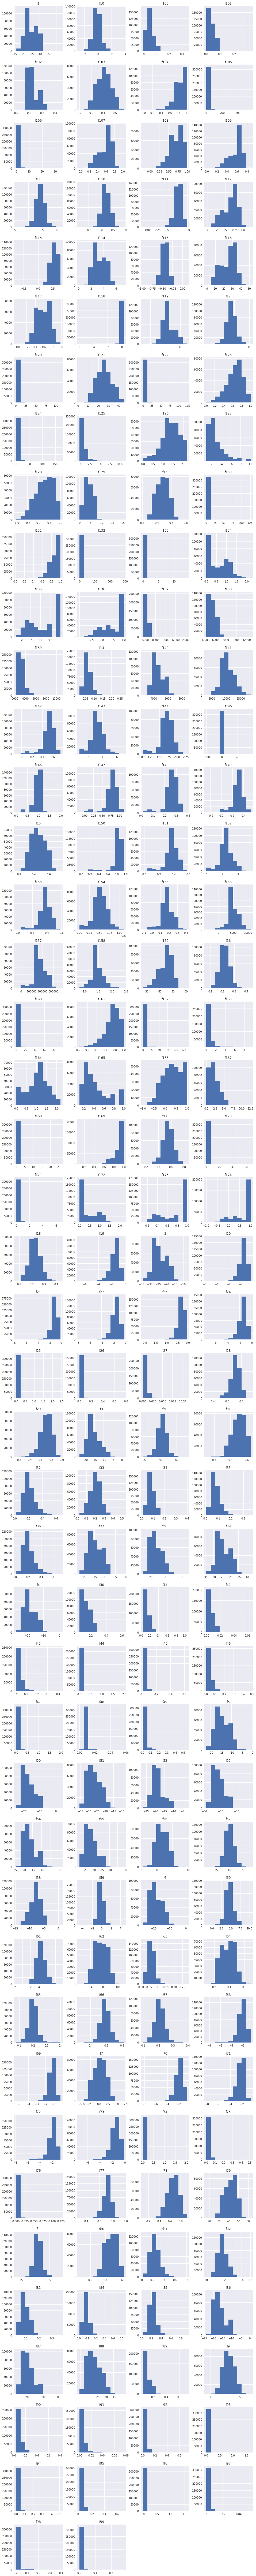

In [29]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

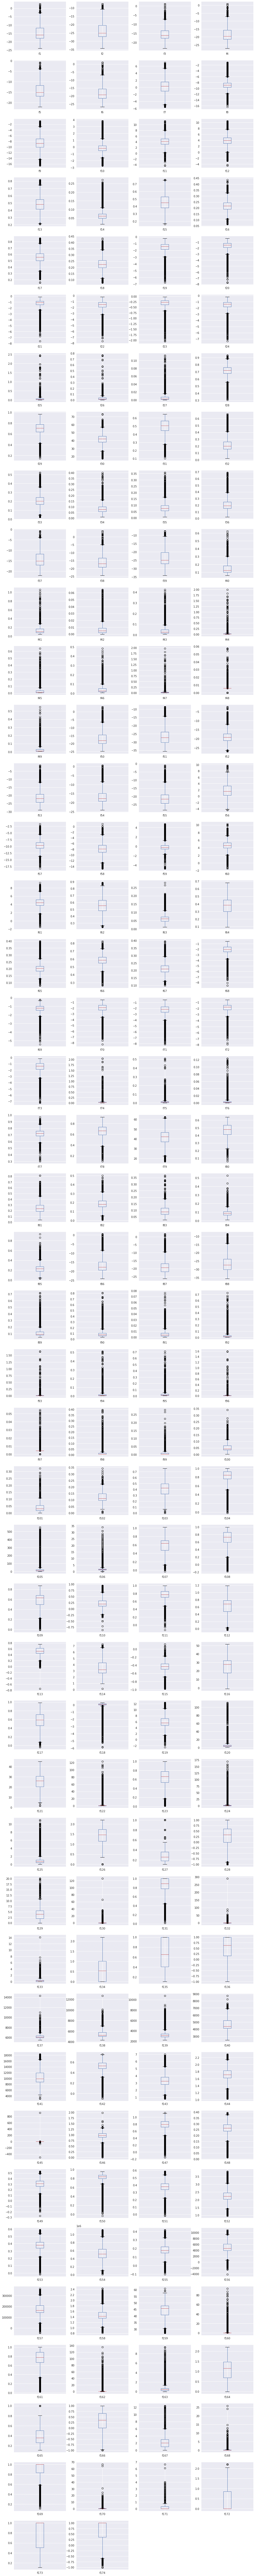

In [30]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

In [31]:
# # Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_original.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [32]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [33]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [34]:
# Split the data further into training and test datasets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
# X_train_val, X_test_df, y_train_val, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
# X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_train_val, y_train_val, test_size=val_set_size, stratify=y_train_val, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))
# print("X_validation_df.shape: {} y_validation_df.shape: {}".format(X_validation_df.shape, y_validation_df.shape))

X_train_df.shape: (260667, 174) y_train_df.shape: (260667,)
X_test_df.shape: (65167, 174) y_test_df.shape: (65167,)


### 3.b) Feature Scaling and Data Pre-Processing

In [35]:
# Gather a list of features for applying the data pre-processing
columns_to_scale = X_train_df.columns[X_train_df.dtypes == 'float64'].tolist()
print('Columns to scale are:', columns_to_scale)

Columns to scale are: ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136

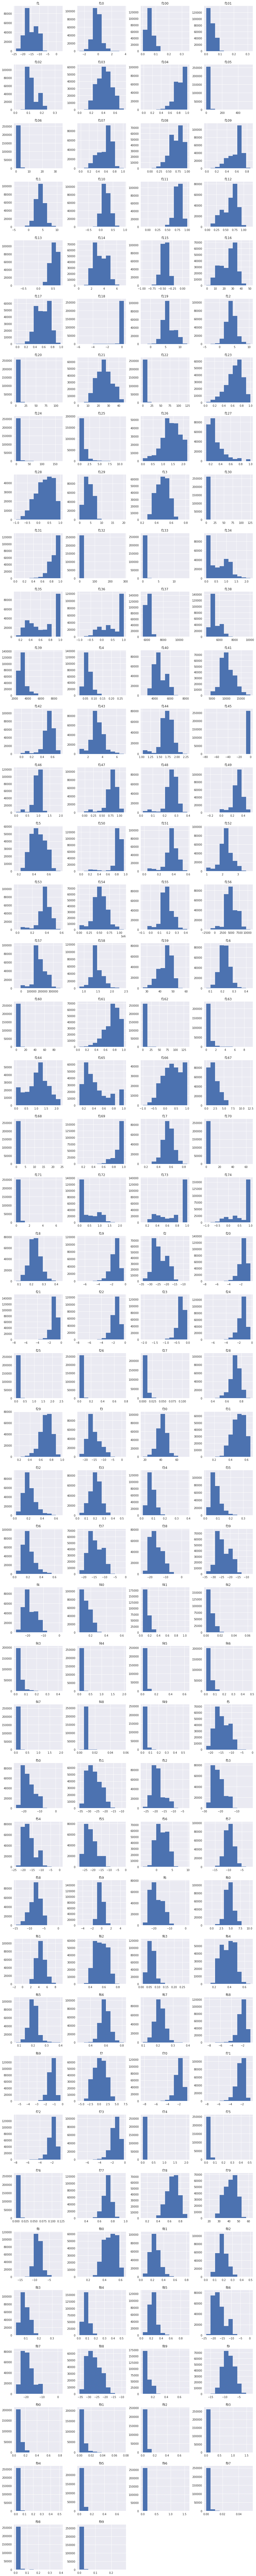

In [36]:
# Histograms for each attribute before pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [37]:
# Apply feature scaling and transformation to the training dataset
scaler = preprocessing.StandardScaler()
X_train_df[columns_to_scale] = scaler.fit_transform(X_train_df[columns_to_scale])
print(X_train_df.head())

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)


              f1        f2        f3        f4        f5        f6        f7        f8        f9       f10  ...      f165      f166  \
263262 -0.710164 -0.627758 -0.630108 -0.481632 -0.766015 -0.692445 -0.255086 -0.047609 -0.242700  1.271823  ... -0.610651 -1.102898   
265057 -1.274695 -1.412364 -1.137205 -1.383798 -1.102893 -1.450245 -0.446037 -1.046252 -1.003332  0.327592  ... -0.811466  0.148732   
313359 -0.207566 -0.668209 -0.533402 -0.544129 -0.196398 -0.713389  0.603804 -1.645023 -0.482085  1.012375  ...  2.301319  1.516459   
141326 -1.209908 -0.931882 -0.915331 -0.887593 -1.276978 -0.802878 -0.742311  0.383240 -0.392640 -0.575449  ... -1.112728 -0.377849   
306546 -0.239817 -0.198333 -0.360187 -0.109344 -0.491871 -0.105191  0.199905  0.029957  0.185808 -0.031911  ... -0.409837 -0.096690   

            f167      f168      f169      f170      f171      f172      f173      f174  
263262 -0.132633 -0.450234  0.758893 -0.481013 -0.734502 -0.839726  0.859148  0.705157  
265057 -0.1

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_array(key, value)


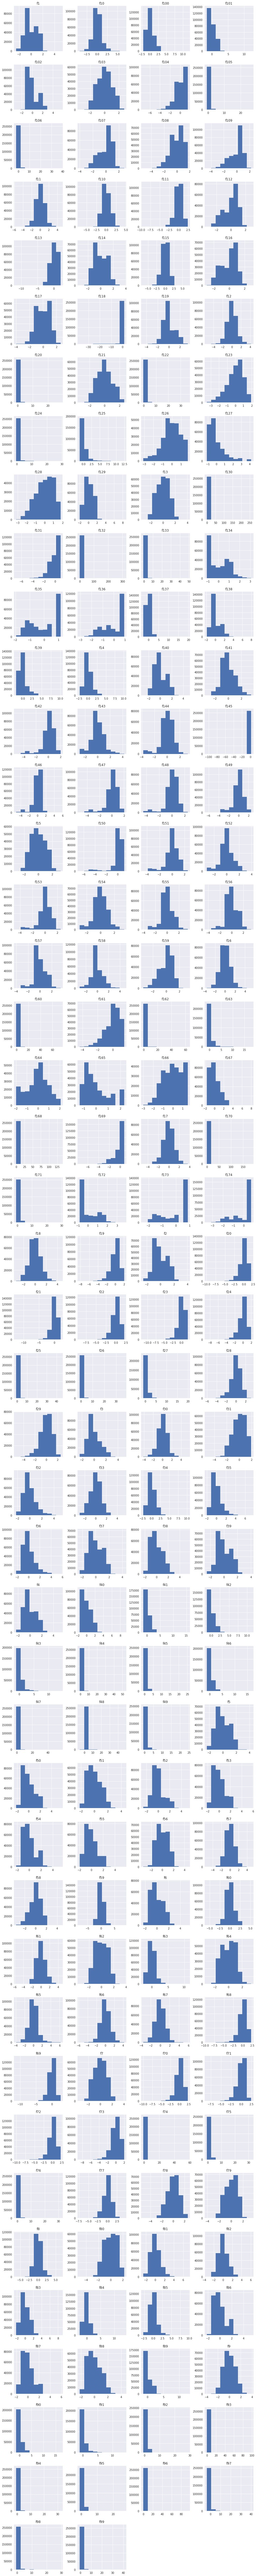

In [38]:
# Histograms for each attribute after pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

### 3.c) Training Data Balancing

In [39]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [40]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [41]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.ravel()
X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (260667, 174) y_train.shape: (260667,)
X_test.shape: (65167, 174) y_test.shape: (65167,)


In [42]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [43]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [44]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('XGB', XGBClassifier(random_state=seedNum, objective='multi:softmax', num_class=7, tree_method='gpu_hist')))

In [45]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.1min finished


LDA: 0.982583 (0.000209)
LinearDiscriminantAnalysis()
Model training time: 0:01:05.638892 



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  8.6min finished


CART: 0.988265 (0.000302)
DecisionTreeClassifier(random_state=888)
Model training time: 0:08:34.028158 



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 141.8min finished


KNN: 0.997138 (0.000255)
KNeighborsClassifier(n_jobs=2)
Model training time: 2:21:45.506285 



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 29.3min finished


BGT: 0.993187 (0.000351)
BaggingClassifier(n_jobs=2, random_state=888)
Model training time: 0:29:19.137404 



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed: 18.9min finished


RNF: 0.996121 (0.000310)
RandomForestClassifier(n_jobs=2, random_state=888)
Model training time: 0:18:54.374823 



[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  3.1min finished


EXT: 0.997242 (0.000372)
ExtraTreesClassifier(n_jobs=2, random_state=888)
Model training time: 0:03:05.271861 

Average metrics (accuracy) from all models: 0.9924226434156066
Total training time for all models: 3:22:49.920204


### 4.b) Spot-checking baseline algorithms

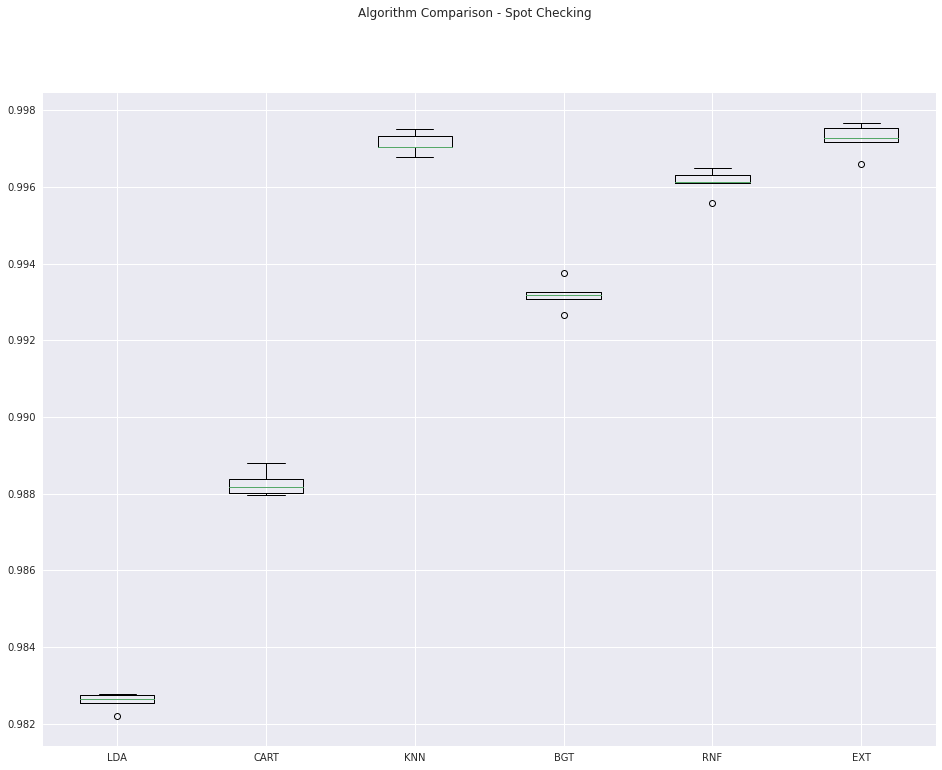

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [47]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [48]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [49]:
# Set up the comparison array
tune_results = []
tune_names = []

In [50]:
# Tuning algorithm #1 - Extra Trees
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_names.append('EXT')
paramGrid1 = dict(n_estimators=np.array([10, 20, 50, 80, 100]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  7.4min finished


Best: 0.997246 using {'n_estimators': 80}
0.995991 (0.000341) with: {'n_estimators': 10}
0.996735 (0.000284) with: {'n_estimators': 20}
0.997100 (0.000355) with: {'n_estimators': 50}
0.997246 (0.000338) with: {'n_estimators': 80}
0.997242 (0.000372) with: {'n_estimators': 100}
Model training time: 0:08:16.207941


In [51]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 80


In [52]:
# Tuning algorithm #2 - k-Nearest Neighbors
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = KNeighborsClassifier(n_jobs=n_jobs)
tune_names.append('KNN')
paramGrid2 = dict(n_neighbors=np.array([5, 10]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed: 261.2min finished


Best: 0.997138 using {'n_neighbors': 5}
0.997138 (0.000255) with: {'n_neighbors': 5}
0.996428 (0.000183) with: {'n_neighbors': 10}
Model training time: 4:22:16.716181


In [53]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_neighbors = 5


### 5.b) Compare Algorithms After Tuning

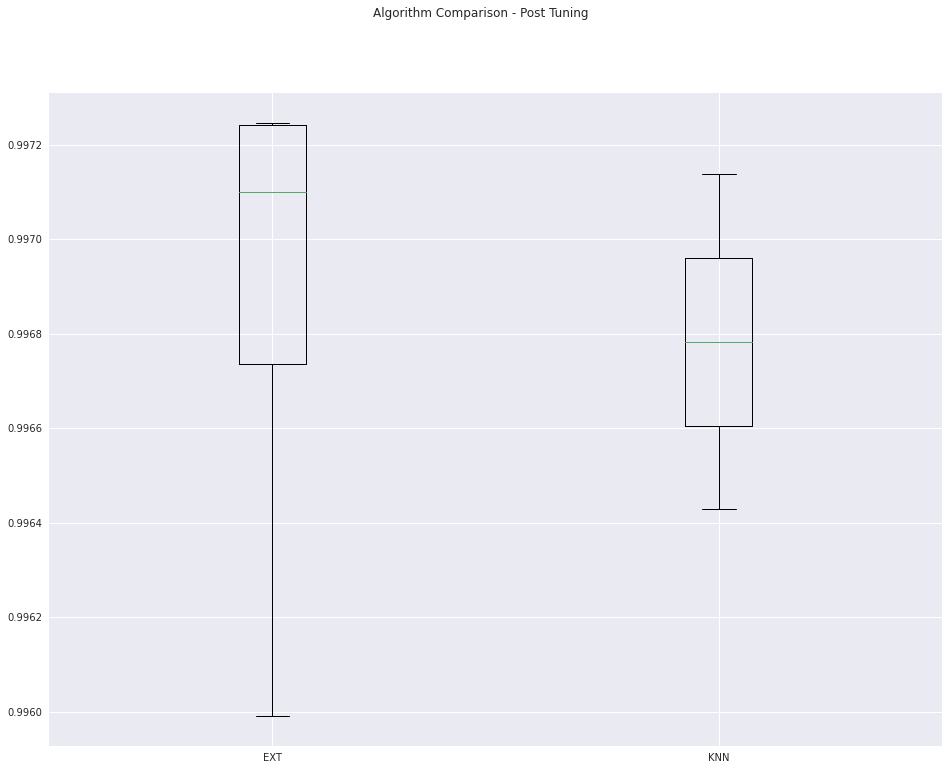

In [54]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_names)
plt.show()

In [55]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [63]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [64]:
# Apply feature scaling and transformation to the test dataset
X_test_df[columns_to_scale] = scaler.transform(X_test_df[columns_to_scale])
print(X_test_df.head())

              f1        f2        f3        f4        f5        f6        f7        f8        f9       f10  ...      f165      f166  \
75386   1.279394  1.549457  0.329612  1.177231  0.725781  1.247479  2.025645  1.494496  2.598276 -0.362368  ... -0.610651 -0.387687   
315080 -0.345702 -0.563628 -0.285821 -0.198780 -0.532020 -0.114167 -0.164682 -0.891950 -0.674302 -0.533498  ...  2.301319  1.516459   
163561 -1.398275 -1.203448 -0.845556 -0.965714 -1.218636 -1.056113 -1.270553  0.016254 -1.056739  0.500766  ...  0.293054 -1.172719   
312398 -0.420478 -0.280222 -0.640513 -0.368222 -0.594754 -0.476747  0.368530  0.280096  0.477652  0.647621  ... -0.409837 -0.880457   
18169   0.889246  1.030990  1.423374  1.104767  1.136370  1.205318 -0.913131  0.884015 -0.235113 -0.553592  ... -1.012280 -0.745293   

            f167      f168      f169      f170      f171      f172      f173      f174  
75386   0.645878 -0.450234  0.758893 -0.481013 -0.734502 -0.839726  0.859148  0.705157  
315080  2.2

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [65]:
# Display information about the test dataset for spot-checking
X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (65167, 174) y_test.shape: (65167,)


In [66]:
test_model1 = ExtraTreesClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
test_model1.fit(X_train, y_train)
predictions1 = test_model1.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model1)

Accuracy Score: 0.99742200807157
[[ 7814     0     0    11     2     2     3]
 [    0   718     0     2     0     0     0]
 [    0     0 15123     6     2     4     0]
 [    5     0     9 14779    10    10     0]
 [    0     1     5    22  9362    32     1]
 [    3     0     2     9    24 16975     2]
 [    0     0     1     0     0     0   228]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7832
           2       1.00      1.00      1.00       720
           3       1.00      1.00      1.00     15135
           4       1.00      1.00      1.00     14813
           5       1.00      0.99      0.99      9423
           6       1.00      1.00      1.00     17015
           7       0.97      1.00      0.98       229

    accuracy                           1.00     65167
   macro avg       0.99      1.00      1.00     65167
weighted avg       1.00      1.00      1.00     65167

ExtraTreesClassifier(n_estimators=80, n_jobs=2, random

In [67]:
test_model2 = KNeighborsClassifier(n_neighbors=best_paramValue2, n_jobs=n_jobs)
test_model2.fit(X_train, y_train)
predictions2 = test_model2.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions2))
print(confusion_matrix(y_test, predictions2))
print(classification_report(y_test, predictions2))
print(test_model2)

Accuracy Score: 0.9971457946506668
[[ 7815     1     0     9     2     2     3]
 [    0   719     1     0     0     0     0]
 [    0     1 15127     3     1     3     0]
 [    3     0     6 14792     7     5     0]
 [    0     0    10    19  9347    45     2]
 [    5     0     1     9    37 16958     5]
 [    3     0     1     0     2     0   223]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7832
           2       1.00      1.00      1.00       720
           3       1.00      1.00      1.00     15135
           4       1.00      1.00      1.00     14813
           5       0.99      0.99      0.99      9423
           6       1.00      1.00      1.00     17015
           7       0.96      0.97      0.97       229

    accuracy                           1.00     65167
   macro avg       0.99      0.99      0.99     65167
weighted avg       1.00      1.00      1.00     65167

KNeighborsClassifier(n_jobs=2)


### 6.b) Create a standalone model using all available data

In [68]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
# X_complete = np.vstack((X_train, X_test))
# y_complete = np.concatenate((y_train, y_test))
# print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
# final_model = test_model1.fit(X_complete, y_complete)
# print(final_model)

### 6.c) Save the final model for later use

In [69]:
# modelName = 'FinalModel_MultiClass.sav'
# dump(final_model, modelName)

In [70]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [71]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 9:54:15.904517
